In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import utils


# Gaussian process regression 

## Lecture 1: Introduction & basics

### Suzanne Aigrain, University of Oxford

#### Saas Fee School 2020: Astronomy in the Era of Big Data

- Monday (1h): 
  - Introduction & basics of GP regression
- Tuesday (1h): 
  - Exercises: basic GP regression in Python
- Wednesday (1h): 
  - Covariance functions and model selection
- Thursday (2h): 
  - Speeding up GP regression
  - Exercises: using `george`
- Friday (2h)
  - Advanced examples
  - Exercises: <font color="red">TBC</font>

In most data analysis we do, the individual observations were assumed to be independent of each other.

$$
\mathcal{L} = \prod_i \mathcal{L}_i
$$

This is almost **never** true in real life. If working with time-series data, it **cannot** be true (causation implies correlation).

So what do we do? Parametrise the the correlations between data points, and learn the parameters from the data.

## What are GPs?

- flexible, robust probabilistic regression and classification tools. 

- applied across a wide range of fields, from finance to zoology. 

- useful for data containing non-trivial stochastic signals or noise.

- particularly popular for time-series data

- increasingly popular in astronomy [mainly time-domain, but not just].

## Many things are equivalent to (specific kinds of) GPs

- least-squares fitting (diagonal covariance)

- linear basis regression with *infinite* numbers of basis functions

- ARMA (AutoRegressive Moving Average) models 

- Kalman Filters

- random forest

- ...

#### Spitzer exoplanet transits and eclipses (Evans et al. 2015)

<img src="images/Evans_Spitzer.png" width="800">

#### GPz photometric redshifts (Almosallam, Jarvis & Roberts 2016)

<img src="images/Almosallam_GPz.png" width="600">

## Further reading

- [*Gaussian Processes: a quick introduction*](https://arxiv.org/abs/1505.02965) by Mark Ebden, arXiv:1505.02965v2

- [*Gaussian Processes for Machine Learning*](http://www.gaussianprocess.org/gpml/) by C. E. Rasmussen & C. Williams, MIT Press, 2006. Associated `Matlab` package `GPML`.

- [*Pattern Recognition and Machine Learning*](https://www.springer.com/gp/book/9780387310732) by Christopher Bishop, Springer Verlag, 2006. 

##  Modelling data with white Gaussian noise

Consider a dataset $\mathcal{D}=\{(x_i,y_i,\sigma_i)\}_{i=1,\ldots,N}$, where $x_i$ is the $i^{\rm th}$ ***input*** (independent variable, for example time), $y_i$ the corresponding ***output*** (depedent variable, or observable), and $\sigma_i$ is the (known) measurement uncertainty associated with $y_i$.

We model the observations as
$$
y_i = m(x_i,\boldsymbol{\theta}) + e_i,
$$
where $m$ is a ***model function*** with ***parameters*** $\boldsymbol{\theta}$, and $e_i$ is the measurement error on $y_i$.

We assume that $e_i$ is drawn from a ***univariate Gaussian distribution*** with variance $\sigma_i$, independently of the other $e$'s.

We can then write the ***likelihood*** for the full dataset as the product of the likelihoods of the individual observations:
$$
\mathcal{L} \equiv p(\mathbf{y}|m,\boldsymbol{\theta},\mathbf{x},\boldsymbol{\sigma}) = \prod_{i=1}^N \left\{ \frac{1}{\sqrt{2 \pi} \sigma_i} \exp \left[-\frac{(y_i-m_i)^2}{2\sigma_i^2} \right] \right\},
$$
where $m_i \equiv m(x_i,\boldsymbol{\theta})$.

Maximising the log likelihood 
$$
\log \mathcal{L} = -0.5 \left\{ N
\log 2\pi + \sum_{i=1}^N \log \sigma_i + \sum_{i=1}^N \left[(y_i-m_i)/\sigma_i\right]^2 \right\}
$$

is thus equivalent to mimising the ***chi-squared***:
$$
\chi^2 = \sum_i \left[ \frac{y_i-m_i}{\sigma_i} \right]^2.
$$

## Generalisation to Gaussian Processes

A more general expression for the likelihood is the $N$-dimensional ***multi-variate Gaussian***:
$$
\mathcal{L} = (2 \pi)^{-N/2} |\mathbf{K}|^{-1/2} \exp \left[- \frac{1}{2} (\mathbf{y}-\mathbf{m})^{\rm T} \mathbf{K}^{-1} (\mathbf{y}-\mathbf{m}) \right]
$$
where $\mathbf{K}$ is a $N \times N$ ***covariance matrix***, with elements $K_{ij}={\rm cov}(r_i,r_j)$, and $|\mathbf{K}|$ is the determinant of $\mathbf{K}$. 

As a shorthand, we write:
$$
\mathcal{L} = \mathcal{N}(\mathbf{y}|\mathbf{m},\mathbf{K}).
$$

A ***Gaussian process*** is a ***stochastic process*** (a collection of random variables indexed by inputs such as time or space), such that any finite collection of those random variables has a multivariate Gaussian distribution. 

White Gaussian noise is a special case of a Gaussian process, where the covariance is purely diagonal:
$$
K_{ij}= \left\{ \begin{array}{ll} \sigma_i^2&~{\rm if}~i=j\\
0&~{\rm if}~i \neq j \end{array} \right.
$$

If the covariance matrix has non-zero off-diagonal values, the noise is ***correlated***.

## From 1 to 2 to $N$ dimensions

Consider a scalar variable $y$, drawn from a univariate Gaussian distribution with mean $\mu$ and variance $\sigma^2$:

$$
p(y) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left[ - \frac{(y-\mu)^2}{2 \sigma^2} \right].
$$

As a short hand, we write: $y \sim \mathcal{N}(\mu,\sigma^2)$.

In [37]:
interact(utils.pltgauss1d,
         sig=widgets.FloatSlider(value=1.0,
                                 min=0.5,
                                 max=2.0,
                                 step=0.25,
                                 description=r'$\sigma$',
                                 readout_format='.2f'));

interactive(children=(FloatSlider(value=1.0, description='$\\sigma$', max=2.0, min=0.5, step=0.25), Output()),…

Now let us consider a pair of variables $y_1$ and $y_2$, drawn from a ***bivariate Gaussian*** distribution. The ***joint probability density*** for $y_1$ and $y_2$ is:

$$
\left[ \begin{array}{l} y_1 \\ y_2 \end{array} \right] \sim \mathcal{N} \left(
\left[ \begin{array}{l} \mu_1 \\ \mu_2 \end{array}  \right] , 
\left[ \begin{array}{ll} 
\sigma_1^2 & C \\
C & \sigma_2^2 
\end{array}  \right] 
\right),
$$

where $C = {\rm cov}(y_1,y_2)$ is the *covariance* between $y_1$ and $y_2$.
The second term on the right hand side is the *covariance matrix*, $K$.

We now use two powerful ***identities*** of Gaussian distributions to elucidate the relationship between $y_1$ and $y_2$. 

The ***marginal distribution*** of $y_1$ describes what we know about $y_1$ in the absence of any other information about $y_2$, and is simply:

$$
p(y_1)= \mathcal{N} (\mu_1,\sigma_1^2).
$$

If we know the value of $y_2$, the probability density for $y_1$ collapses to the the ***conditional distribution*** of $y_1$ ***given*** $y_2$:

$$
p(y_1 \mid y_2) = \mathcal{N} \left( \mu_1 + C (y_2-\mu_2)/\sigma_2^2, \sigma_1^2-C^2\sigma_2^2 \right).
$$

If $K$ is diagonal, i.e. if $C=0$, $p(y_1 \mid y_2) = p(y_1)$. Measuring $y_2$ doesn't teach us anything about $y_1$. The two variables are ***uncorrelated***. 

If the variables are ***correlated*** ($C \neq 0$), measuring $y_2$ does alter our knowledge of $y_1$: it modifies the mean and reduces the variance.

In [5]:
interact(utils.pltgauss2d, 
         rho=widgets.FloatSlider(min=-0.8,max=0.8,step=0.4,description=r'$\rho$',value=0),
         show_cond=widgets.Checkbox(value=True,description='show conditional distribution'));

interactive(children=(FloatSlider(value=0.0, description='$\\rho$', max=0.8, min=-0.8, step=0.4), Checkbox(val…

Let us plot $y_1$ and $y_2$ next to each other, as we normally would if they formed part of a ***time-series***. 

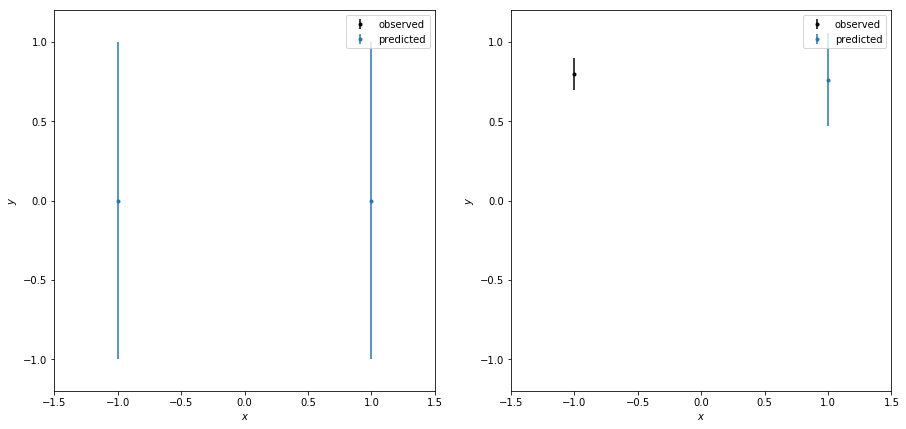

In [36]:
par = [1,0.01] # A, Gamma
pl.figure(figsize=(15,7))
ax1 = pl.subplot(121)
xobs = np.array([])
yobs = np.array([])
eobs = np.array([])
xtest = np.array([-1,1])
utils.Plot_Pred_GP(utils.SEKernel,par,xobs,yobs,eobs,xtest)
xobs = np.array([-1])
yobs = np.array([0.8])
eobs = 0.1
xtest = np.array([1])
pl.subplot(122,sharex=ax1,sharey=ax1)
utils.Plot_Pred_GP(utils.SEKernel,par,xobs,yobs,eobs,xtest)
pl.xlim(-1.5,1.5)
pl.ylim(-1.2,1.2);

Now consider $N$ variables drawn from a ***multivariate Gaussian*** distribution:
$$
\boldsymbol{y} \sim \mathcal{N} (\boldsymbol{m},K)
$$
with ***mean vector*** $m$ and ***covariance matrix*** $K$.

A ***Gaussian process*** is an extension of this concept to infinite $N$, giving rise to a ***probability distribution over functions***. 

This last generalisation may not be obvious conceptually, but in practice only ever deal with finite samples.

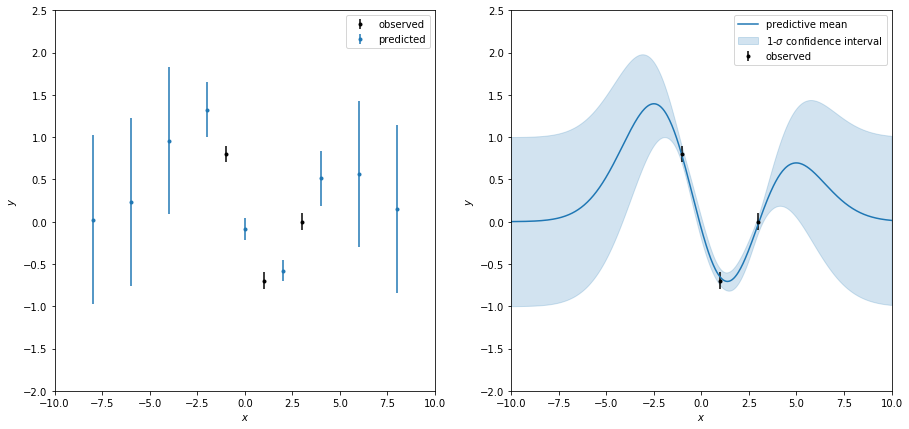

In [34]:
par = [1,0.1] # A, Gamma
pl.figure(figsize=(15,7))
ax1 = pl.subplot(121)
xobs = np.array([-1,1,3])
yobs = np.array([0.8,-0.7,0])
eobs = np.array([0.1,0.1,0.1])
xtest = np.array([-8,-6,-4,-2,0,2,4,6,8])
utils.Plot_Pred_GP(utils.SEKernel,par,xobs,yobs,eobs,xtest)
pl.subplot(122,sharex=ax1,sharey=ax1)
xtest = np.linspace(-10,10,500)
utils.Plot_Pred_GP(utils.SEKernel,par,xobs,yobs,eobs,xtest);
pl.xlim(-10,10)
pl.ylim(-2,2.5);

## Gaussian Process regression

In general, we do not know the covariance matrix *a priori*.

Instead, we define a ***covariance function*** $k$ such that:
$$
K_{ij} = k(x_i,x_j,\boldsymbol{\phi}).
$$
and ***learn*** its parameters $\boldsymbol{\phi}$ from the data (we can also compare different covariance functions).

We then write the Gaussian process as
$$
y(x) \sim \mathcal{GP}(m(x), k(x,x'))
$$

There are many types of covariance function; the only requirement is that the covariance matrix should be ***symmmetric*** ($K_{ij}=K_{ji}$ and ***positive semi-definite*** ($|\mathbf{K}| \geq 0$).

A very common covariance function is the squared exponential, or radial basis function (RBF) kernel
$$
K_{ij}=k(x_i,x_j,\boldsymbol{\phi})=A \exp\left[ - \Gamma (x_i-x_j)^2\right],
$$
which has 2 parameters: $\boldsymbol{\phi}=(A,\Gamma)$.

Here we are implicitly assuming the inputs $x$ are one-dimensional, e.g. $x$ might represent time. However, the input space can have more than one dimension. We will see an example of a GP with multi-dimensional inputs later.

## Test and training sets

Suppose we have an (observed) ***training set*** $(\mathbf{x},\mathbf{y})$. 
We are interested in some other ***test set*** of inputs $\mathbf{x}_*$.

The joint distribution over the training and test sets is

$$
\mathrm{p} \left( \left[ \begin{array}{l} \mathbf{y} \\ \mathbf{y}_* \end{array} \right] \right) 
= \mathcal{N} \left( \left[ \begin{array}{l} \mathbf{m} \\ \mathbf{m}_* \end{array} \right], 
\left[ \begin{array}{ll} \mathbf{K} & \mathbf{K}_* \\ \mathbf{K}_*^{\rm T} & \mathbf{K}_{**} \end{array} \right] \right),
$$

where $\mathbf{m}_* = m(\mathbf{x}_*,\boldsymbol{\theta})$, $K_{**,ij} = k(x_{*,i},x_{*,j},\boldsymbol{\phi})$ and $K_{*,ij} = k(x_i,x_{*,j},\boldsymbol{\phi})$. 

To keep equations uncluttered, from now on we will omit $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$, except where explicitly needed.

For simplicity, we assume initially that the mean function is zero everywhere: $\mathbf{m}=\mathbf{0}$. We will consider to non-trivial mean functions later. 

## The conditional distribution

The ***conditional distribution*** for the test set given the training set is:
$$ 
\mathrm{p} ( \mathbf{y}_* \mid \mathbf{x},\mathbf{y},k,\boldsymbol{\phi},\mathbf{x}_*) = \mathcal{N} ( 
\mathbf{K}_*^{\rm T} \, \mathbf{K}^{-1} \, \mathbf{y}, \mathbf{K}_{**} - \mathbf{K}_*^{\rm T} \, \mathbf{K}^{-1} \, \mathbf{K}_* ).
$$

This is also known as the ***predictive distribution***, because it can be use to predict future (or past) observations. 

More generally, it can be used for ***interpolating*** the observations to any desired set of inputs. 

This is one of the most widespread applications of GPs in some fields (e.g. kriging in geology, economic forecasting, ...)

### Adding white noise

Real observations always contain a component of ***white noise***, which we need to account for, but don't necessarily want to include in the predictions. 

If the white noise variance $\sigma^2$ is constant, we simply add a constant term to the covariance matrix of the training set:
$$ 
\mathrm{p} ( \mathbf{y}_* \mid \mathbf{x},\mathbf{y},k,\boldsymbol{\phi},\mathbf{x}_*) = \mathcal{N} \left( 
\mathbf{K}_*^{\rm T} \, (\mathbf{K}+\sigma^2 \mathbb{I})^{-1} \, \mathbf{y}, \mathbf{K}_{**} - \mathbf{K}_*^{\rm T} \, (\mathbf{K} + \sigma^2 \mathbb{I})^{-1} \, \mathbf{K}_* \right).
$$
where $\mathbb{I}$ is the identity matrix.

It's trivial to allow for different $\sigma$ for each data point.

## Single-point prediction

Let us look more closely at the predictive distribution for a single test point $x_*$.

It is a Gaussian with mean and variance
$$
\begin{array}{lll}
\mathbb{E}[y_*] \equiv \overline{y_*} & = & \mathbf{k}_*^{\rm T} \, (\mathbf{K} + \sigma^2 \mathbb{I})^{-1} \, \mathbf{y}, \\
\mathbb{V}[y_*] & = & k(x_*,x_*,\boldsymbol{\phi}) - \mathbf{k}_*^{\rm T} \, (\mathbf{K} + \sigma^2 \mathbb{I})^{-1} \, \mathbf{k}_*,
\end{array}
$$
where $\mathbf{k}_*$ is the vector of covariances between the test point and the training points, such that $k_{*,i}=k(x_i,x_*)$.

This is a generalisation of the bivariate expression we saw earlier.

Notice the mean is a linear combination of the observations: the GP is a ***linear predictor***.

It is also a linear combination of covariance functions, each centred on a training point:
$$
\overline{y_*} = \sum_{i=1}^N \alpha_i k(x_i,x_*,\boldsymbol{\phi}),
$$
where $\alpha_i = (\mathbf{K} + \sigma^2 \mathbb{I})^{-1} \, y_i$.

## The likelihood

The ***likelihood*** of the data under the GP model is simply:
$$
\mathrm{p}(\mathbf{y} \mid \mathbf{x},k,\boldsymbol{\phi}) = \mathcal{N}(\mathbf{y} \mid \mathbf{0},\mathbf{K} + \sigma^2 \mathbb{I}).
$$

This is a measure of how well the model explains, or predicts, the training set.

In some textbooks this is referred to as the ***marginal likelihood***. 

This arises if one considers the observed $\mathbf{y}$ as noisy realisations of a latent (unobserved) Gaussian process $f$.

The term ***marginal*** refers to marginalisation over the function values $\boldsymbol{f}$:
$$
\mathrm{p}(\mathbf{y} \mid \mathbf{x}) = \int \mathrm{p}(\mathbf{y} \mid \mathbf{f},\mathbf{x}) \, \mathrm{p}(\mathbf{f} \mid \mathbf{x}) \, \mathrm{d} \mathbf{f},
$$
where $\mathbf{f} \equiv f(\mathbf{x})$, and
$$
\mathrm{p}(\mathbf{f} \mid \mathbf{x}) = \mathcal{N}(\mathbf{f} \mid \mathbf{0},K)
$$
is the ***prior***, and 
$$
\mathrm{p}(\mathbf{y} \mid \mathbf{f},\mathbf{x}) = \mathcal{N}(\mathbf{y} \mid \mathbf{0},\sigma^2 \mathbb{I})
$$
is the ***likelihood***.

## Parameters and hyper-parameters 

The parameters of the covariance and mean function as known as the ***hyper-parameters*** of the GP. 

This is because the actual ***parameters*** of the model are the function values, $\mathbf{f}$, but we never explicitly deal with them: they are always marginalised over.

## *Conditioning* the GP...

...means evaluating the conditional (or predictive) distribution for a given covariance matrix (i.e. covariance function and hyper-parameters), and training set.

## *Training* the GP...

...means maximising the *likelihood* of the model with respect to the hyper-parameters.

## The kernel trick

Consider a linear basis model with arbitrarily many ***basis functions***, or ***features***, $\boldsymbol{\Phi}(x)=(\Phi_1(x),\Phi_2(x),\ldots,\Phi_M(x))$, where $M$ is the number of basis functions, and a Gaussian prior with covariance matrix $\boldsymbol{\Sigma}$ over the basis function weights. 

One ends up with exactly the same expressions for the predictive distribution and the likelihood as in the GP case, so long as:
$$
k(x,x') = \boldsymbol{\Phi}^{\rm T}(x) \, \boldsymbol{\Sigma} \, \boldsymbol{\Phi}(x'),
$$
or, writing $\boldsymbol{\Psi}(x) = \boldsymbol{\Sigma}^{1/2} \, \boldsymbol{\Phi}(x)$,
$$
k(x,x') = \boldsymbol{\Psi}(x) \cdot \boldsymbol{\Psi}(x'),
$$

Thus the covariance function $k$ enables us to go from a (finite) ***input space*** to a (potentially infinite) ***feature space***. This is known as the ***kernel trick*** and the covariance function is often referred to as the ***kernel***.

## Non-zero mean functions

In general (and in astronomy applications in particular) we often want to use non-trivial mean functions.

To do this simply replace $\mathbf{y}$ by $\mathbf{r}=\mathbf{y}-\mathbf{m}$ in the expressions for predictive distribution and likelihood.

The mean function represents the ***deterministic*** component of the model
- e.g.: a linear trend, a Keplerian orbit, a planetary transit, ...

The covariance function encodes the ***stochastic*** component. 
- e.g.: instrumental noise, stellar variability

# Tutorial 1

- write your own (simple) GP code with Squared Exponential covariance function
- vary / fit for the hyper-parameters
- (sample the posterior?)